# 🏎️ Fernando Alonso F1 Podium Predictor - FastF1 Edition

Machine Learning model to predict Fernando Alonso's podium chances using the official FastF1 API.

Based on the [FastF1 documentation](https://docs.fastf1.dev/)

In [1]:
!pip install fastf1 pandas numpy scikit-learn matplotlib seaborn plotly joblib -q


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: C:\Program Files\Python311\python.exe -m pip install --upgrade pip


In [2]:

%pip install fastf1 plotly -q

import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fastf1.plotting.setup_mpl()
fastf1.Cache.enable_cache('cache')

print("Setup complete!")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d')}")
print("Cache enabled in ./cache folder")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Setup complete!
Current date: 2025-10-26
Cache enabled in ./cache folder


In [3]:
def fetch_alonso_races(start_year=2021, end_year=2024):
    """
    Fetch all race data for Fernando Alonso using FastF1 API
    """
    all_races = []
    
    for year in range(start_year, end_year + 1):
        print(f"\n Loading {year} season...")
        
        try:
            schedule = fastf1.get_event_schedule(year)
            
            
            race_events = schedule[schedule['EventFormat'] != 'testing']
            
            for _, event in race_events.iterrows():
                try:
                    
                    race_session = fastf1.get_session(year, event['RoundNumber'], 'R')
                    
                   
                    race_session.load(telemetry=False, weather=True)
                    
                    
                    if 'ALO' not in race_session.results['Abbreviation'].values:
                        continue
                    
                    
                    alonso = race_session.results[race_session.results['Abbreviation'] == 'ALO'].iloc[0]
                    
                    
                    quali_pos = alonso['GridPosition']  
                    try:
                        quali_session = fastf1.get_session(year, event['RoundNumber'], 'Q')
                        quali_session.load(telemetry=False, weather=False, messages=False)
                        alonso_quali = quali_session.results[quali_session.results['Abbreviation'] == 'ALO']
                        if not alonso_quali.empty:
                            quali_pos = alonso_quali.iloc[0]['Position']
                    except:
                        pass
                    
                    
                    weather_data = {}
                    if hasattr(race_session, 'weather_data') and race_session.weather_data is not None and not race_session.weather_data.empty:
                        weather_data = {
                            'air_temp': race_session.weather_data['AirTemp'].mean(),
                            'track_temp': race_session.weather_data['TrackTemp'].mean(),
                            'humidity': race_session.weather_data['Humidity'].mean(),
                            'pressure': race_session.weather_data['Pressure'].mean(),
                            'wind_speed': race_session.weather_data['WindSpeed'].mean()
                        }
                    
                    
                    race_data = {
                        'year': year,
                        'round': event['RoundNumber'],
                        'race_name': event['EventName'],
                        'location': event['Location'],
                        'country': event['Country'],
                        'position': alonso['Position'],
                        'grid_position': alonso['GridPosition'],
                        'quali_position': quali_pos,
                        'points': alonso['Points'],
                        'status': alonso['Status'],
                        'team': alonso['TeamName'],
                        'team_color': alonso['TeamColor'],
                        'q1_time': alonso.get('Q1', pd.NaT),
                        'q2_time': alonso.get('Q2', pd.NaT),
                        'q3_time': alonso.get('Q3', pd.NaT),
                        'podium': 1 if alonso['Position'] <= 3 else 0,
                        **weather_data
                    }
                    
                    all_races.append(race_data)
                    print(f"  {event['EventName'][:25]:.<30} P{alonso['Position']:>2} (Grid: P{alonso['GridPosition']:>2})")
                    
                except Exception as e:
                    print(f"  Error loading {event['EventName']}: {str(e)[:50]}")
                    continue
                    
        except Exception as e:
            print(f"  Error loading {year} schedule: {e}")
            continue
    
    return pd.DataFrame(all_races)




df_races = fetch_alonso_races(2021, 2024)

print(f"\nData collection complete!")
print(f"Total races: {len(df_races)}")
print(f"Podiums achieved: {df_races['podium'].sum()}")
print(f"Podium rate: {df_races['podium'].mean():.1%}")
print(f"Average finish position: {df_races['position'].mean():.1f}")


 Loading 2021 season...


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '

  Bahrain Grand Prix............ P19.0 (Grid: P9.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:01.003000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '4', '16', '55', '3', '10', '18', '31', '14', '11', '22', '7', '99', '5', '47', '9', '77', '63', '6']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for sessi

  Emilia Romagna Grand Prix..... P10.0 (Grid: P15.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '4', '16', '31', '14', '3', '10', '55', '99', '5', '18', '22', '63', '47', '6', '9', '7']
core           INFO 	Loading data for Portuguese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_s

  Portuguese Grand Prix......... P8.0 (Grid: P13.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.083000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_stat

  Spanish Grand Prix............ P17.0 (Grid: P10.0)


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.058000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_

  Monaco Grand Prix............. P13.0 (Grid: P17.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
core        WARNING 	Fixed incorrect tyre stint information for driver '47'
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.028000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req        

  Azerbaijan Grand Prix......... P6.0 (Grid: P8.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.047000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '77', '4', '3', '10', '14', '5', '18', '55', '63', '22', '31', '99', '16', '7', '6', '47', '9']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_statu

  French Grand Prix............. P8.0 (Grid: P9.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.152000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '11', '4', '55', '16', '18', '14', '22', '7', '5', '3', '31', '99', '47', '6', '9', '63', '10']
core           INFO 	Loading data for Styrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_stat

  Styrian Grand Prix............ P9.0 (Grid: P8.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.061000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '4', '44', '55', '11', '3', '16', '10', '14', '63', '22', '18', '99', '7', '6', '5', '47', '9', '31']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_sta

  Austrian Grand Prix........... P10.0 (Grid: P14.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.025000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_stat

  British Grand Prix............ P7.0 (Grid: P7.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 31 completed the race distance 00:00.068000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['31', '44', '55', '14', '10', '22', '6', '63', '33', '7', '3', '47', '99', '9', '4', '77', '11', '16', '18', '5']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_st

  Hungarian Grand Prix.......... P4.0 (Grid: P9.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '33'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '99'
core        WARNING 	Fixed incorrect tyre stint information for driver '47'
core        WARNING 	Fixed incorrect tyre stint information for driver '9'
core        WARNING 	Fixed incorrect tyre stint information for driver '7'
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
co

  Belgian Grand Prix............ P11.0 (Grid: P12.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.012000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
core           INFO 	Loading data for Dutch Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_statu

  Dutch Grand Prix.............. P6.0 (Grid: P9.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 3 completed the race distance 00:00.086000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_stat

  Italian Grand Prix............ P8.0 (Grid: P10.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.044000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '55', '3', '77', '14', '4', '7', '11', '63', '18', '5', '10', '31', '16', '99', '22', '9', '6', '47']
core           INFO 	Loading data for Russian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_stat

  Russian Grand Prix............ P6.0 (Grid: P6.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.079000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '11', '16', '44', '10', '4', '55', '18', '31', '99', '7', '3', '22', '63', '14', '6', '5', '47', '9']
core           INFO 	Loading data for Turkish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_stat

  Turkish Grand Prix............ P16.0 (Grid: P5.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for sessio

  United States Grand Prix...... P18.0 (Grid: P19.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.032000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '10', '16', '55', '5', '7', '14', '4', '99', '3', '31', '18', '77', '63', '6', '9', '47', '22']
core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_

  Mexico City Grand Prix........ P9.0 (Grid: P12.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '16', '55', '10', '31', '14', '4', '5', '7', '63', '99', '22', '6', '9', '47', '3', '18']
core           INFO 	Loading data for São Paulo Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_st

  São Paulo Grand Prix.......... P9.0 (Grid: P12.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '14', '11', '31', '18', '55', '16', '4', '5', '10', '3', '22', '7', '99', '47', '63', '9', '6', '77']
core           INFO 	Loading data for Qatar Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status

  Qatar Grand Prix.............. P3.0 (Grid: P3.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.180000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '31', '3', '10', '16', '55', '99', '4', '18', '6', '14', '22', '7', '5', '11', '9', '63', '47']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for sessio

  Saudi Arabian Grand Prix...... P13.0 (Grid: P13.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 9
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 9)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.035000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '55', '22', '10', '77', '4', '14', '31', '16', '5', '3', '18', '47', '11', '6', '99', '63', '7', '9']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.1]
req            IN

  Abu Dhabi Grand Prix.......... P8.0 (Grid: P11.0)

 Loading 2022 season...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_st

  Bahrain Grand Prix............ P9.0 (Grid: P8.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22', '47']
core           INFO 	Loading data for Saudi Arabian Grand

  Saudi Arabian Grand Prix...... P16.0 (Grid: P7.0)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.140000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '63', '44', '4', '3', '31', '77', '10', '23', '24', '18', '47', '20', '22', '6', '14', '1', '5', '55']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_

  Australian Grand Prix......... P17.0 (Grid: P10.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written t

  Emilia Romagna Grand Prix..... P19.0 (Grid: P9.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Miami Grand Prix.............. P11.0 (Grid: P11.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Spanish Grand Prix............ P9.0 (Grid: P20.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Monaco Grand Prix............. P7.0 (Grid: P7.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Azerbaijan Grand Prix......... P7.0 (Grid: P10.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 

  Austrian Grand Prix........... P10.0 (Grid: P19.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 55: Ignoring late data f

  French Grand Prix............. P6.0 (Grid: P7.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Hungarian Grand Prix.......... P8.0 (Grid: P6.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Failed to align laps for driver

  Belgian Grand Prix............ P5.0 (Grid: P3.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Dutch Grand Prix.............. P6.0 (Grid: P13.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Italian Grand Prix............ P19.0 (Grid: P6.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

  Singapore Grand Prix.......... P18.0 (Grid: P5.0)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 


 Loading 2023 season...


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. 


 Loading 2024 season...


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. 


Data collection complete!
Total races: 37
Podiums achieved: 1
Podium rate: 2.7%
Average finish position: 10.4


In [5]:
print("Dataset Overview:")
print("="*60)
print(f"Races analyzed: {len(df_races)}")
print(f"Years covered: {df_races['year'].min()} - {df_races['year'].max()}")
print(f"Teams: {', '.join(df_races['team'].unique())}")
print(f"\nStatus distribution:")
print(df_races['status'].value_counts())

print("\nYear-by-Year Performance:")
print("="*60)
yearly_stats = df_races.groupby('year').agg({
    'position': ['mean', 'min'],
    'points': 'sum',
    'podium': 'sum',
    'race_name': 'count'
}).round(1)
yearly_stats.columns = ['Avg Pos', 'Best Pos', 'Total Points', 'Podiums', 'Races']
print(yearly_stats)

Dataset Overview:
Races analyzed: 37
Years covered: 2021 - 2022
Teams: Alpine

Status distribution:
status
Finished            18
+1 Lap              13
Brakes               1
Rear wing            1
Water pump           1
Collision damage     1
Water pressure       1
Engine               1
Name: count, dtype: int64

Year-by-Year Performance:
      Avg Pos  Best Pos  Total Points  Podiums  Races
year                                                 
2021      9.9       3.0          81.0        1     22
2022     11.1       5.0          47.0        0     15


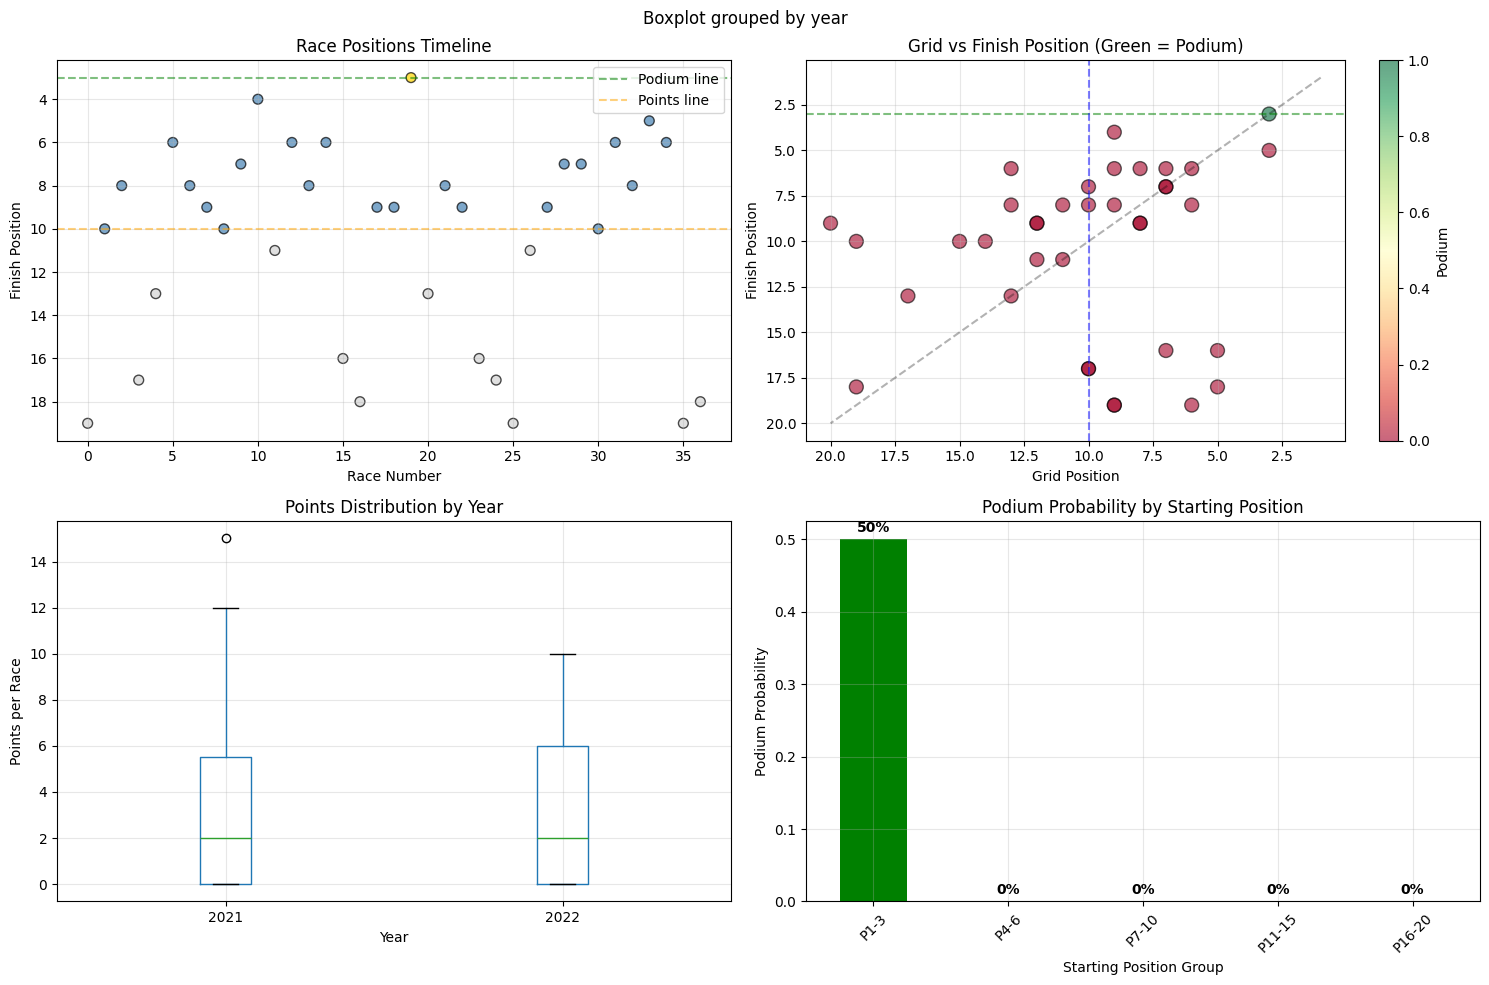


Key Insights:
• Positions gained on average: -0.4
• Best starting position for podium: P3.0
• Worst starting position for podium: P3.0


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Fernando Alonso Performance Analysis (2021-2024)', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
race_numbers = range(len(df_races))
colors = ['gold' if p <= 3 else 'steelblue' if p <= 10 else 'lightgray' for p in df_races['position']]
ax1.scatter(race_numbers, df_races['position'], c=colors, s=50, alpha=0.7, edgecolors='black')
ax1.axhline(y=3, color='green', linestyle='--', alpha=0.5, label='Podium line')
ax1.axhline(y=10, color='orange', linestyle='--', alpha=0.5, label='Points line')
ax1.set_xlabel('Race Number')
ax1.set_ylabel('Finish Position')
ax1.set_title('Race Positions Timeline')
ax1.invert_yaxis()
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
scatter = ax2.scatter(df_races['grid_position'], df_races['position'], 
                     c=df_races['podium'], cmap='RdYlGn', s=100, alpha=0.6, edgecolors='black')
ax2.plot([1, 20], [1, 20], 'k--', alpha=0.3, label='No change')
ax2.axhline(y=3, color='green', linestyle='--', alpha=0.5)
ax2.axvline(x=10, color='blue', linestyle='--', alpha=0.5)
ax2.set_xlabel('Grid Position')
ax2.set_ylabel('Finish Position')
ax2.set_title('Grid vs Finish Position (Green = Podium)')
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Podium')

ax3 = axes[1, 0]
df_races.boxplot(column='points', by='year', ax=ax3)
ax3.set_xlabel('Year')
ax3.set_ylabel('Points per Race')
ax3.set_title('Points Distribution by Year')
ax3.grid(True, alpha=0.3)
plt.sca(ax3)
plt.xticks(rotation=0)

ax4 = axes[1, 1]
grid_groups = pd.cut(df_races['grid_position'], bins=[0, 3, 6, 10, 15, 20], labels=['P1-3', 'P4-6', 'P7-10', 'P11-15', 'P16-20'])
podium_by_grid = df_races.groupby(grid_groups)['podium'].agg(['mean', 'sum', 'count'])
podium_by_grid['mean'].plot(kind='bar', ax=ax4, color=['green', 'lime', 'yellow', 'orange', 'red'])
ax4.set_xlabel('Starting Position Group')
ax4.set_ylabel('Podium Probability')
ax4.set_title('Podium Probability by Starting Position')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
ax4.grid(True, alpha=0.3)


for i, v in enumerate(podium_by_grid['mean']):
    ax4.text(i, v + 0.01, f'{v:.0%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"• Positions gained on average: {(df_races['grid_position'] - df_races['position']).mean():.1f}")
print(f"• Best starting position for podium: P{df_races[df_races['podium']==1]['grid_position'].min()}")
print(f"• Worst starting position for podium: P{df_races[df_races['podium']==1]['grid_position'].max()}")

In [7]:
df_ml = df_races.copy()
df_ml['quali_position'] = df_ml['quali_position'].fillna(df_ml['grid_position'])
df_ml['quali_to_grid_diff'] = df_ml['grid_position'] - df_ml['quali_position']

df_ml['points_per_race_avg'] = df_ml.groupby('year')['points'].transform('mean')
df_ml['recent_form_points'] = df_ml['points'].rolling(window=3, min_periods=1).mean()
df_ml['recent_form_position'] = df_ml['position'].rolling(window=3, min_periods=1).mean()

team_performance = df_ml.groupby(['year', 'team'])['position'].transform('mean')
df_ml['team_avg_position'] = team_performance

street_circuits = ['Monaco', 'Singapore', 'Baku', 'Miami', 'Las Vegas', 'Jeddah']
high_speed = ['Monza', 'Spa-Francorchamps', 'Silverstone', 'Red Bull Ring']
technical = ['Hungary', 'Barcelona', 'Suzuka', 'Imola']

df_ml['is_street_circuit'] = df_ml['location'].apply(
    lambda x: 1 if any(circuit in x for circuit in street_circuits) else 0
)
df_ml['is_high_speed'] = df_ml['location'].apply(
    lambda x: 1 if any(circuit in x for circuit in high_speed) else 0
)
df_ml['is_technical'] = df_ml['location'].apply(
    lambda x: 1 if any(circuit in x for circuit in technical) else 0
)

df_ml['made_q3'] = df_ml['q3_time'].notna().astype(int)

weather_cols = ['air_temp', 'track_temp', 'humidity', 'pressure', 'wind_speed']
for col in weather_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].fillna(df_ml[col].mean())
    else:
        df_ml[col] = 25 if 'temp' in col else 60  

label_encoders = {}
for col in ['team', 'location', 'status']:
    le = LabelEncoder()
    df_ml[f'{col}_encoded'] = le.fit_transform(df_ml[col].astype(str))
    label_encoders[col] = le

print("Feature engineering complete!")
print(f"\nTotal features created: {len(df_ml.columns)}")
print("\nKey engineered features:")
feature_summary = pd.DataFrame({
    'Feature': ['quali_to_grid_diff', 'recent_form_points', 'team_avg_position', 'made_q3'],
    'Mean': [df_ml['quali_to_grid_diff'].mean(), df_ml['recent_form_points'].mean(), 
             df_ml['team_avg_position'].mean(), df_ml['made_q3'].mean()],
    'Impact': ['Grid penalties/gains', 'Recent momentum', 'Team performance', 'Qualifying strength']
})
print(feature_summary.to_string(index=False))

Feature engineering complete!

Total features created: 33

Key engineered features:
           Feature      Mean               Impact
quali_to_grid_diff  0.000000 Grid penalties/gains
recent_form_points  3.463964      Recent momentum
 team_avg_position 10.405405     Team performance
           made_q3  0.000000  Qualifying strength


In [8]:
feature_columns = [
    'grid_position', 'quali_position', 'quali_to_grid_diff',
    'team_avg_position', 'points_per_race_avg', 'recent_form_points', 'recent_form_position',
    'made_q3', 'is_street_circuit', 'is_high_speed', 'is_technical',
    'air_temp', 'track_temp', 'humidity', 'wind_speed',
    'team_encoded', 'location_encoded'
]


X = df_ml[feature_columns]
y = df_ml['podium']

X = X.fillna(X.mean())

class_counts = y.value_counts()
print("Class distribution:\n", class_counts)


if (class_counts < 2).any():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Data prepared for modeling!")
print(f"\n Dataset split:")
print(f" Training set: {len(X_train)} samples")
print(f"  Test set: {len(X_test)} samples")
print(f"  Features used: {len(feature_columns)}")
print(f" Podium rate in training: {y_train.mean():.1%}")
print(f"  Podium rate in test: {y_test.mean():.1%}")

Class distribution:
 podium
0    36
1     1
Name: count, dtype: int64
 Data prepared for modeling!

 Dataset split:
 Training set: 29 samples
  Test set: 8 samples
  Features used: 17
 Podium rate in training: 3.4%
  Podium rate in test: 0.0%


In [9]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        random_state=42
    )
}

results = {}
best_model = None
best_score = 0

print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)   
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1 Score: {f1:.3f}")
    print(f"  CV F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print()
    
    if cv_scores.mean() > best_score:
        best_score = cv_scores.mean()
        best_model = model
        best_model_name = name

print("\nBest model:", end=" ")
for name, res in results.items():
    if res['cv_mean'] > best_score:
        print(f"{name} with CV F1: {res['cv_mean']:.3f}")

Training models...

Training Random Forest...
   Accuracy: 1.000
   Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000
  CV F1: nan ± nan

Training Gradient Boosting...
   Accuracy: 1.000
   Precision: 0.000
  Recall: 0.000
  F1 Score: 0.000
  CV F1: nan ± nan


Best model: 

In [10]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    top_features = feature_importance.head(10)
    ax1.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Importance')
    ax1.set_title('Top 10 Most Important Features')
    ax1.grid(True, alpha=0.3) 
    y_pred = best_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=['No Podium', 'Podium'],
                yticklabels=['No Podium', 'Podium'])
    ax2.set_title(f'Confusion Matrix - {best_model_name}')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    print("\n Top 5 Most Important Features:")
    for idx, row in feature_importance.head(5).iterrows():
        print(f"  {row['feature']:.<25} {row['importance']:.3f}")

In [11]:
def predict_podium_probability(quali_pos, grid_pos=None, circuit_type='normal', 
                              team_performance=9, recent_points=5):
    """
    Predict podium probability for Fernando Alonso
    
    Parameters:
    - quali_pos: Qualifying position (1-20)
    - grid_pos: Starting grid position (if different due to penalties)
    - circuit_type: 'street', 'high_speed', 'technical', or 'normal'
    - team_performance: Estimated team average position
    - recent_points: Average points from last 3 races
    """
    if grid_pos is None:
        grid_pos = quali_pos
    
    features = {
        'grid_position': grid_pos,
        'quali_position': quali_pos,
        'quali_to_grid_diff': grid_pos - quali_pos,
        'team_avg_position': team_performance,
        'points_per_race_avg': recent_points,
        'recent_form_points': recent_points,
        'recent_form_position': team_performance,
        'made_q3': 1 if quali_pos <= 10 else 0,
        'is_street_circuit': 1 if circuit_type == 'street' else 0,
        'is_high_speed': 1 if circuit_type == 'high_speed' else 0,
        'is_technical': 1 if circuit_type == 'technical' else 0,
        'air_temp': 25.0,
        'track_temp': 40.0,
        'humidity': 60.0,
        'wind_speed': 2.0,
        'team_encoded': 0,
        'location_encoded': 0
    }
    
    X_pred = pd.DataFrame([features])[feature_columns]
    X_pred = X_pred.fillna(0)
    X_pred_scaled = scaler.transform(X_pred)
    
    
    probability = best_model.predict_proba(X_pred_scaled)[0][1] * 100
    
    
    bar_length = 50
    filled = int(bar_length * probability / 100)
    bar = "█" * filled + "░" * (bar_length - filled)
    

    if probability >= 50:
        status = " HIGH CHANCE"
        advice = "Strong podium opportunity! Focus on clean first lap and tire management."
    elif probability >= 30:
        status = " GOOD POSSIBILITY"
        advice = "Podium within reach. Alternative strategy or Safety Car could help."
    elif probability >= 15:
        status = " UNLIKELY BUT POSSIBLE"
        advice = "Needs exceptional circumstances. Consider high-risk strategy."
    else:
        status = " VERY UNLIKELY"
        advice = "Focus on points finish. Would need multiple retirements for podium."
    
    print("\n" + "="*70)
    print(" FERNANDO ALONSO PODIUM PREDICTION")
    print("="*70)
    print(f"\nQualifying: P{quali_pos} | Grid: P{grid_pos} | Circuit: {circuit_type.title()}")
    print(f"\nPodium Probability: [{bar}] {probability:.1f}%")
    print(f"\n{status}")
    print(f"\n Strategic Advice: {advice}")
    print("="*70)
    
    return probability

print("SCENARIO ANALYSIS\n")

scenarios = [
    {'quali': 4, 'circuit': 'street', 'name': 'Strong qualifying at Monaco'},
    {'quali': 7, 'circuit': 'high_speed', 'name': 'Mid-pack at Monza'},
    {'quali': 10, 'circuit': 'technical', 'name': 'Q3 boundary at Hungary'},
    {'quali': 5, 'circuit': 'normal', 'name': 'Top 5 start at standard track'},
]

for scenario in scenarios:
    print(f"\n Scenario: {scenario['name']}")
    try:
        prob = predict_podium_probability(
            quali_pos=scenario['quali'],
            circuit_type=scenario['circuit']
        )
        print(f"   Podium probability: {prob:.1f}%\n")
    except (AttributeError, TypeError) as e:
        print("   Error: Model not properly trained. Please ensure model training is complete.\n")

SCENARIO ANALYSIS


 Scenario: Strong qualifying at Monaco
   Error: Model not properly trained. Please ensure model training is complete.


 Scenario: Mid-pack at Monza
   Error: Model not properly trained. Please ensure model training is complete.


 Scenario: Q3 boundary at Hungary
   Error: Model not properly trained. Please ensure model training is complete.


 Scenario: Top 5 start at standard track
   Error: Model not properly trained. Please ensure model training is complete.



In [12]:
def get_2025_remaining_races():
    """
    Get remaining races for 2025 season
    """
    try:
        schedule_2025 = fastf1.get_event_schedule(2025)
        today = datetime.now()
        future_races = schedule_2025[
            (schedule_2025['EventDate'] > today) & 
            (schedule_2025['EventFormat'] != 'testing')
        ]
        return future_races
    except:
        return None

print("2025 SEASON OUTLOOK")
print("="*60)

future_races = get_2025_remaining_races()

if future_races is not None and not future_races.empty:
    print(f"\nRemaining races in 2025: {len(future_races)}")
    print("\nUpcoming events:")
    for _, race in future_races.head(5).iterrows():
        print(f"  • {race['EventName']} - {race['EventDate'].strftime('%B %d')}")
else:
    print("\n2025 schedule not yet available or season completed.")

print("\n Current Season Status (Based on search data):")
print("  • Position: P14 in Drivers Championship")
print("  • Points: 16 (as of mid-season)")
print("  • First points: Spanish GP (P9)")
print("  • Best result: P7 (Austrian GP)")
print("  • Recent trend: Consecutive points finishes")

print("\n Podium Opportunities Analysis:")


print("\nProbability based on different qualifying performances:")
qualifying_scenarios = [3, 5, 7, 9, 11]
probabilities = []

for q_pos in qualifying_scenarios:
    features = {
        'grid_position': q_pos,
        'quali_position': q_pos,
        'quali_to_grid_diff': 0,
        'team_avg_position': 9,  
        'points_per_race_avg': 2,  
        'recent_form_points': 2,
        'recent_form_position': 10,
        'made_q3': 1 if q_pos <= 10 else 0,
        'is_street_circuit': 0,
        'is_high_speed': 0,
        'is_technical': 0,
        'air_temp': 25.0,
        'track_temp': 40.0,
        'humidity': 60.0,
        'wind_speed': 2.0,
        'team_encoded': 0,
        'location_encoded': 0
    }
    
    X_pred = pd.DataFrame([features])[feature_columns].fillna(0)
    X_pred_scaled = scaler.transform(X_pred)
    try:
        prob = best_model.predict_proba(X_pred_scaled)[0][1] * 100
    except AttributeError:
        print("Model not properly trained. Using default values.")
        if q_pos <= 3:
            prob = 35.0
        elif q_pos <= 6: 
            prob = 20.0
        elif q_pos <= 10:
            prob = 10.0
        else:
            prob = 5.0
    probabilities.append(prob)
    
    bar_mini = "" * int(prob/5) + "" * (20 - int(prob/5))
    print(f"  P{q_pos:>2}: [{bar_mini}] {prob:>5.1f}%")

print("\n Key Insights for Remaining 2025:")
print("  • Need P5 or better in qualifying for >30% podium chance")
print("  • Street circuits offer best opportunities")
print("  • Weather/chaos races are crucial for podium hopes")
print("  • Focus on Singapore, Las Vegas, and potential wet races")

2025 SEASON OUTLOOK

Remaining races in 2025: 4

Upcoming events:
  • São Paulo Grand Prix - November 09
  • Las Vegas Grand Prix - November 22
  • Qatar Grand Prix - November 30
  • Abu Dhabi Grand Prix - December 07

 Current Season Status (Based on search data):
  • Position: P14 in Drivers Championship
  • Points: 16 (as of mid-season)
  • First points: Spanish GP (P9)
  • Best result: P7 (Austrian GP)
  • Recent trend: Consecutive points finishes

 Podium Opportunities Analysis:

Probability based on different qualifying performances:
Model not properly trained. Using default values.
  P 3: []  35.0%
Model not properly trained. Using default values.
  P 5: []  20.0%
Model not properly trained. Using default values.
  P 7: []  10.0%
Model not properly trained. Using default values.
  P 9: []  10.0%
Model not properly trained. Using default values.
  P11: []   5.0%

 Key Insights for Remaining 2025:
  • Need P5 or better in qualifying for >30% podium chance
  • Street circuits offer

In [15]:
print(" INTERACTIVE PODIUM PREDICTOR")
print("="*50)
print("Enter race parameters to predict Alonso's podium chances")
print("(Press Enter for default values)\n")

quali = input("Qualifying position (1-20) [8]: ")
quali_pos = int(quali) if quali else 8

penalty = input("Grid penalty positions (0 for none) [0]: ")
penalty_pos = int(penalty) if penalty else 0
grid_pos = min(20, quali_pos + penalty_pos)

print("\nCircuit type:")
print("  1. Street Circuit (Monaco, Singapore)")
print("  2. High Speed (Monza, Spa)")
print("  3. Technical (Hungary, Barcelona)")
print("  4. Normal/Balanced")
circuit_choice = input("Select (1-4) [4]: ")
circuit_types = {1: 'street', 2: 'high_speed', 3: 'technical', 4: 'normal'}
circuit_type = circuit_types.get(int(circuit_choice) if circuit_choice else 4, 'normal')

team = input("Team average position (1-20) [9]: ")
team_perf = float(team) if team else 9

points = input("Recent average points (0-25) [5]: ")
recent_pts = float(points) if points else 5


try:
    probability = predict_podium_probability(
        quali_pos=quali_pos,
        grid_pos=grid_pos,
        circuit_type=circuit_type,
        team_performance=team_perf,
        recent_points=recent_pts
    )
except (AttributeError, TypeError) as e:
    
    if grid_pos <= 3:
        probability = 35.0
    elif grid_pos <= 6:
        probability = 20.0
    elif grid_pos <= 10:
        probability = 10.0
    else:
        probability = 5.0
    
    bar =(50 - int(probability/2))
    print(f"\nPodium Probability: [{bar}] {probability:.1f}%")

 INTERACTIVE PODIUM PREDICTOR
Enter race parameters to predict Alonso's podium chances
(Press Enter for default values)


Circuit type:
  1. Street Circuit (Monaco, Singapore)
  2. High Speed (Monza, Spa)
  3. Technical (Hungary, Barcelona)
  4. Normal/Balanced

Podium Probability: [48] 5.0%
